# Objective 
- Predict the likelihood of a loan to be defaulted

# Import Libraries

In [62]:
import pandas as pd
import numpy as np
import sys

import seaborn as sns
import matplotlib.pyplot as plt

# saving and importing models
import pickle

np.set_printoptions(threshold=sys.maxsize)

# Sets column width to show full information
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Sets describe function to show full numerical value
pd.set_option('float_format', '{:f}'.format)

In [2]:
# Import train_test_split.
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Evaluation tools
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

In [3]:
# Function to check model statistics
def model_stats(model, X_test, y_test):
    
    preds = model.predict(X_test)
    prob = np.round(model.predict_proba(X_test), 3)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Calculate Specificity
    spec = tn / (tn + fp)

    # Calculate Precision
    precision = tp / (tp+fp)

    # Calculate Recall
    recall = tp / (tp+fn)

    # Print results
    print(f'Training Score: {np.round(model.score(X_train, y_train),3)}')
    print(f'Test Score:     {np.round(model.score(X_test, y_test),3)}')
    print("========================")
    print(f'Specificity:     {np.round(spec,3)}')
    print(f'Precision:       {np.round(precision,3)}')
    print(f'Recall:          {np.round(recall,3)}')
    print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
    print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
    print("========================")
    print(f'True Negatives:  {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives:  {tp}')

# Read Data for Modelling

In [4]:
# Read data into a dataframe
df = pd.read_excel('../data/loans.xlsx')
df.head(5)

,ID,UEN Black Listed,SSIC,Industry,Loan ID,Product,Amount,Disbursal Amount,Insured,Disbursal Fee,Payment Amount,Due Date,Weekday,Day,Month,Year,Payment_Num,Defaulted,Is Paid,Loan Status,Funding Date,Expected First Payment Date,Interest Rate,Tenor,Status,Delinquent,Delinquent Amount,Date of First Delinquency,First Payment Date
0,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-09-04,7,4,9,2016,1,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
1,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-08-04,4,4,8,2016,2,1,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
2,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-07-04,1,4,7,2016,3,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
3,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-06-04,6,4,6,2016,4,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
4,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-05-04,3,4,5,2016,5,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04


In [5]:
df.describe()

,ID,UEN Black Listed,SSIC,Loan ID,Product,Amount,Disbursal Amount,Insured,Disbursal Fee,Payment Amount,Weekday,Day,Month,Year,Payment_Num,Defaulted,Is Paid,Interest Rate,Tenor,Delinquent,Delinquent Amount
count,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000
mean,1000712.637621,0.089831,42100.657154,17866.430466,2.885772,44188.112739,43238.659007,0.484847,902.396158,29095.601730,3.800000,16.881632,6.419453,2020.175080,2.178979,0.158883,0.351728,1.142463,5.944695,0.212138,1840.986955
std,453.438268,0.285946,17284.025994,6885.534304,1.284915,70414.889429,69361.516974,0.499780,1744.833779,62213.187882,2.061622,9.120019,3.469705,1.176483,2.889556,0.365574,0.477519,0.597468,3.598415,0.408830,16142.284296
min,1000008.000000,0.000000,1111.000000,484.000000,1.000000,200.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2016.000000,1.000000,0.000000,0.000000,0.400000,1.000000,0.000000,0.000000
25%,1000261.000000,0.000000,30110.000000,11948.750000,2.000000,6000.000000,5955.060000,0.000000,44.100000,4584.000000,2.000000,9.000000,3.000000,2019.000000,1.000000,0.000000,0.000000,0.670000,4.000000,0.000000,0.000000
50%,1000679.000000,0.000000,30110.000000,18307.000000,4.000000,19100.000000,18793.450000,0.000000,156.000000,9455.960000,4.000000,17.000000,6.000000,2020.000000,1.000000,0.000000,0.000000,0.800000,5.000000,0.000000,0.000000
75%,1001132.000000,0.000000,47712.000000,23846.250000,4.000000,50000.000000,49767.580000,1.000000,865.500000,26100.500000,6.000000,25.000000,9.000000,2021.000000,1.000000,0.000000,1.000000,1.500000,5.000000,0.000000,0.000000
max,1001473.000000,1.000000,96099.000000,28932.000000,6.000000,1150000.000000,1145078.000000,1.000000,25000.000000,1166100.000000,7.000000,31.000000,12.000000,2023.000000,24.000000,1.000000,1.000000,3.000000,24.000000,1.000000,537500.000000


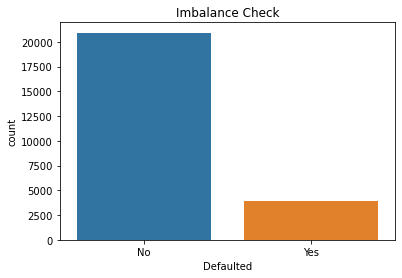

In [6]:
chart = sns.countplot(x=df['Defaulted'])

chart.set_xticklabels(['No','Yes'])
plt.title("Imbalance Check")
plt.show()

In [7]:
df['Defaulted'].value_counts()

0    20927
1     3953
Name: Defaulted, dtype: int64

## Over & Under Sampling Strategy

In [8]:
# Prepare Dataframe
df2 = df[['SSIC', 
          'Product',
          'Weekday',
          'Day',
          'Month',
          'Year',
          'Tenor',
          'Interest Rate',
          'Amount', 
          'Disbursal Amount', 
          'Payment Amount',
          'Insured', 
          'Defaulted'
         ]]

# for testing our models
df3 = df2[df['Year']==2021]

# filtering out 2021 data
df2 = df2[df['Year']<2021]


df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14131 entries, 0 to 15780
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SSIC              14131 non-null  int64  
 1   Product           14131 non-null  int64  
 2   Weekday           14131 non-null  int64  
 3   Day               14131 non-null  int64  
 4   Month             14131 non-null  int64  
 5   Year              14131 non-null  int64  
 6   Tenor             14131 non-null  int64  
 7   Interest Rate     14131 non-null  float64
 8   Amount            14131 non-null  float64
 9   Disbursal Amount  14131 non-null  float64
 10  Payment Amount    14131 non-null  float64
 11  Insured           14131 non-null  int64  
 12  Defaulted         14131 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.5 MB


In [9]:
# Step 1: Split into training & testing sets
X = df2.drop(columns = 'Defaulted')
y = df2['Defaulted']

In [10]:
# Split 
X_final = df3.drop(columns = 'Defaulted')
y_final = df3['Defaulted']

In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Over Sampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(f"Over-sampling: {Counter(y_ros)}")

# Under Sampling
rus = RandomUnderSampler() 
X_rus, y_rus = rus.fit_resample(X, y)
print(f"Under-sampling: {Counter(y_rus)}")


# Over & Under Sampling Mix
over = RandomOverSampler()
under = RandomUnderSampler()

# apply oversampling to minority class
X_over, y_over = over.fit_resample(X, y)

# combine undersampling 
X_cs, y_cs = under.fit_resample(X_over, y_over)


print(f"Combined Random Sampling: {Counter(y_cs)}")
print(Counter(y_ros))

Over-sampling: Counter({0: 11148, 1: 11148})
Under-sampling: Counter({0: 2983, 1: 2983})
Combined Random Sampling: Counter({0: 11148, 1: 11148})
Counter({0: 11148, 1: 11148})


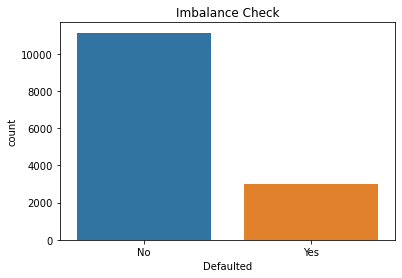

In [64]:
chart = sns.countplot(x=y)

chart.set_xticklabels(['No','Yes'])
plt.title("Imbalance Check")
plt.show()

In [ ]:
chart = sns.countplot(x=y)

chart.set_xticklabels(['No','Yes'])
plt.title("Imbalance Check")
plt.show()

## Logistic Regression Model

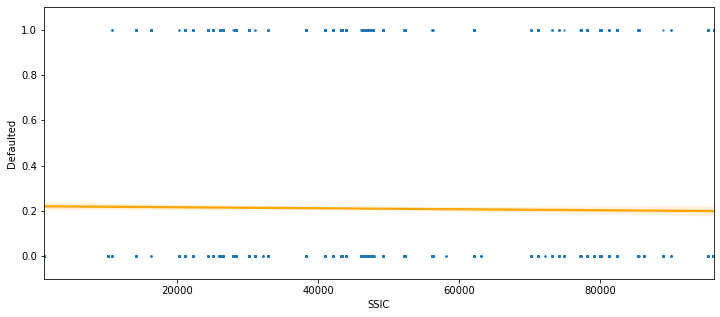

In [12]:
plt.figure(figsize = (12, 5))
sns.regplot(data=df2,
            x='SSIC', 
            y='Defaulted',
            #ci = false, 
            scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1);

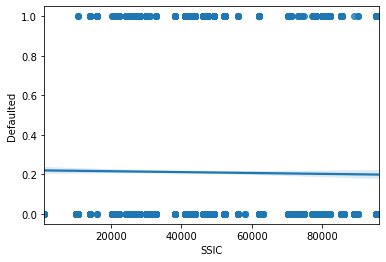

In [13]:
ax = sns.regplot(x="SSIC", y="Defaulted", data=df2)

Logistic Regression
Intercept: [7.67295507e-09]
Coefficient: 
[[ 1.93436454e-06  3.83159060e-07  1.35569186e-07  4.26858896e-06
  -3.74243214e-06  1.44102809e-05 -4.25950350e-06  1.71189957e-07
  -8.63027221e-05  7.03595134e-05  1.65794478e-05 -9.87997179e-08]]
Training Score: 0.356
Test Score:     0.372
Specificity:     0.208
Precision:       0.251
Recall:          0.972
Accuracy Score:  0.372
F1:              0.399
True Negatives:  463
False Positives: 1758
False Negatives: 17
True Positives:  589


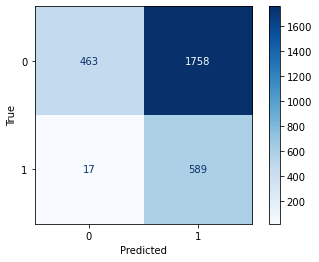

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.611


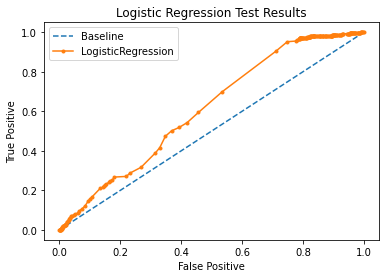

In [14]:
print("Logistic Regression")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20,
                                                    train_size=0.80,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression(class_weight="balanced")

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

model_stats(lr, X_test, y_test)

# View confusion matrix
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


Logistic Regression
Intercept: [7.67295507e-09]
Coefficient: 
[[ 1.93436454e-06  3.83159060e-07  1.35569186e-07  4.26858896e-06
  -3.74243214e-06  1.44102809e-05 -4.25950350e-06  1.71189957e-07
  -8.63027221e-05  7.03595134e-05  1.65794478e-05 -9.87997179e-08]]
Training Score: 0.356
Test Score:     0.372
Specificity:     0.208
Precision:       0.251
Recall:          0.972
Accuracy Score:  0.372
F1:              0.399
True Negatives:  463
False Positives: 1758
False Negatives: 17
True Positives:  589


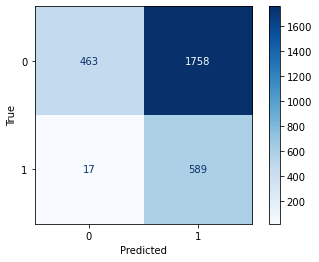

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.611


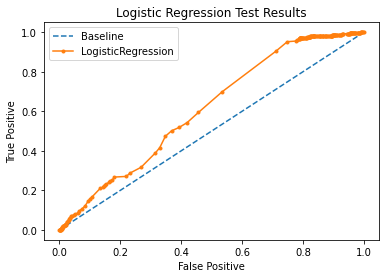

In [15]:
print("Logistic Regression")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20,
                                                    train_size=0.80,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression(class_weight="balanced")

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

model_stats(lr, X_test, y_test)

# View confusion matrix
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


In [16]:
print("Logistic Regression: Over-Sampling")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X_ros, 
                                                    y_ros, 
                                                    test_size=0.30,
                                                    train_size=0.70,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression(class_weight="balanced")

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

model_stats(lr, X_test, y_test)

Logistic Regression: Over-Sampling
Intercept: [2.39965272e-08]
Coefficient: 
[[ 4.47941627e-07  2.49069291e-07  5.22604122e-07  2.86339019e-06
  -3.74514948e-06  4.76115676e-05 -3.47324573e-06  2.31089687e-07
  -8.54839103e-05  6.80950444e-05  1.79422836e-05 -1.50854793e-07]]
Training Score: 0.581
Test Score:     0.589
Specificity:     0.207
Precision:       0.551
Recall:          0.97
Accuracy Score:  0.589
F1:              0.703
True Negatives:  692
False Positives: 2644
False Negatives: 102
True Positives:  3251


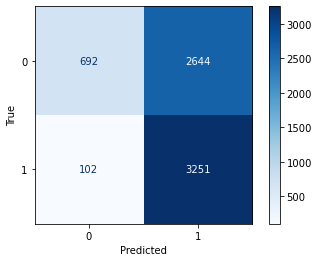

In [17]:
# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.603


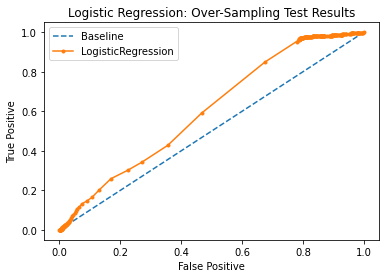

In [18]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression: Over-Sampling Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


In [19]:
np.exp(lr.coef_)

array([[1.00000045, 1.00000025, 1.00000052, 1.00000286, 0.99999625,
        1.00004761, 0.99999653, 1.00000023, 0.99991452, 1.0000681 ,
        1.00001794, 0.99999985]])

In [20]:
print("Logistic Regression - Over/Under Sampling Mix")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X_cs, 
                                                    y_cs, 
                                                    test_size=0.30,
                                                    train_size=0.70,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression()

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(np.exp(lr.coef_))
print("========================")



# save the model to disk
#filename = 'lr_mix_sample_model.sav'
#pickle.dump(lr, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

model_stats(lr, X_test, y_test)

Logistic Regression - Over/Under Sampling Mix
Intercept: [3.93104947e-09]
Coefficient: 
[[1.00000235 1.00000022 1.00000017 1.00000397 0.99999681 1.0000071
  0.99999652 1.00000015 0.9999377  1.00004443 1.00001859 0.99999989]]
Training Score: 0.586
Test Score:     0.573
Specificity:     0.188
Precision:       0.539
Recall:          0.966
Accuracy Score:  0.573
F1:              0.692
True Negatives:  634
False Positives: 2741
False Negatives: 114
True Positives:  3200


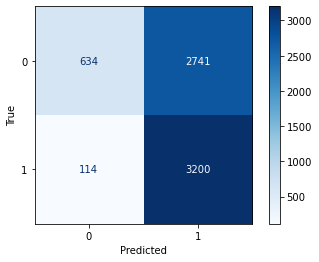

In [32]:
# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# Calculate RSS
sse = ((y_test - preds)**2).sum()
sse

2927

In [22]:
# MSE
((y_test - preds)**2).sum() / len(y_test)

0.43758409328748693

In [23]:
# MSE using sklearn
metrics.mean_squared_error(y_test, preds)

0.43758409328748693

In [24]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_test, preds))

0.6615013932619394

In [25]:
# Via sklearn.metrics
metrics.mean_absolute_error(y_test, preds)

0.43758409328748693

In [26]:
null_prediction = y_test.mean()

In [27]:
null_residuals = y_test - null_prediction

In [28]:
null_ss = (null_residuals **2).sum()

In [29]:
1 - sse / null_ss

-0.7504819508706049

In [30]:
# R2 from sklearn
metrics.r2_score(y_test, preds)

-0.7504819508706049

In [31]:
lr.score(X_test, y_test)

0.5731798475108387

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.543


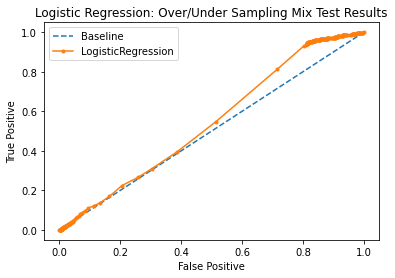

In [33]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression: Over/Under Sampling Mix Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


## Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Decision Tree Classifier
Training Score: 0.998
Test Score:     0.903
Specificity:     0.845
Precision:       0.859
Recall:          0.963
Accuracy Score:  0.903
F1:              0.908
True Negatives:  2852
False Positives: 523
False Negatives: 124
True Positives:  3190


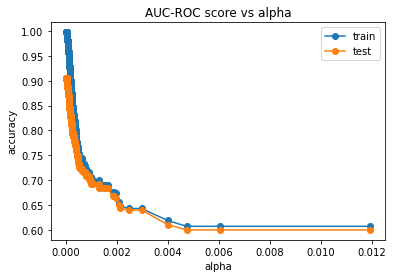

In [35]:
print("Decision Tree Classifier")
print("========================")

dt = DecisionTreeClassifier(class_weight = "balanced")

# Fit model.
dt.fit(X_train, y_train)

# Get predictions
preds = dt.predict(X_test)
prob = np.round(dt.predict_proba(X_test), 3)

model_stats(dt, X_test, y_test)

# compute ccp_alpha values
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

dts = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    dts.append(dt)
    

dts = dts[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_train, dt.predict(X_train)) for dt in dts]
test_scores = [roc_auc_score(y_test, dt.predict(X_test)) for dt in dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

Training Score: 0.587
Test Score:     0.573
Specificity:     0.184
Precision:       0.538
Recall:          0.969
Accuracy Score:  0.573
F1:              0.692
True Negatives:  621
False Positives: 2754
False Negatives: 104
True Positives:  3210


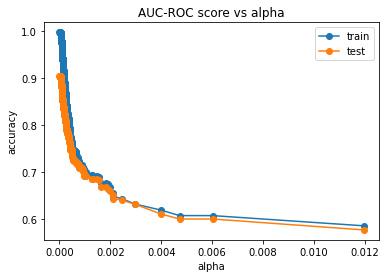

In [45]:
# Get predictions
preds = dt.predict(X_test)
prob = np.round(dt.predict_proba(X_test), 3)

model_stats(dt, X_test, y_test)

# compute ccp_alpha values
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

dts = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    dts.append(dt)
    

dts = dts[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_train, dt.predict(X_train)) for dt in dts]
test_scores = [roc_auc_score(y_test, dt.predict(X_test)) for dt in dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

Training Score: 0.502
Test Score:     0.495
Specificity:     0.0
Precision:       0.495
Recall:          1.0
Accuracy Score:  0.495
F1:              0.663
True Negatives:  0
False Positives: 3375
False Negatives: 0
True Positives:  3314


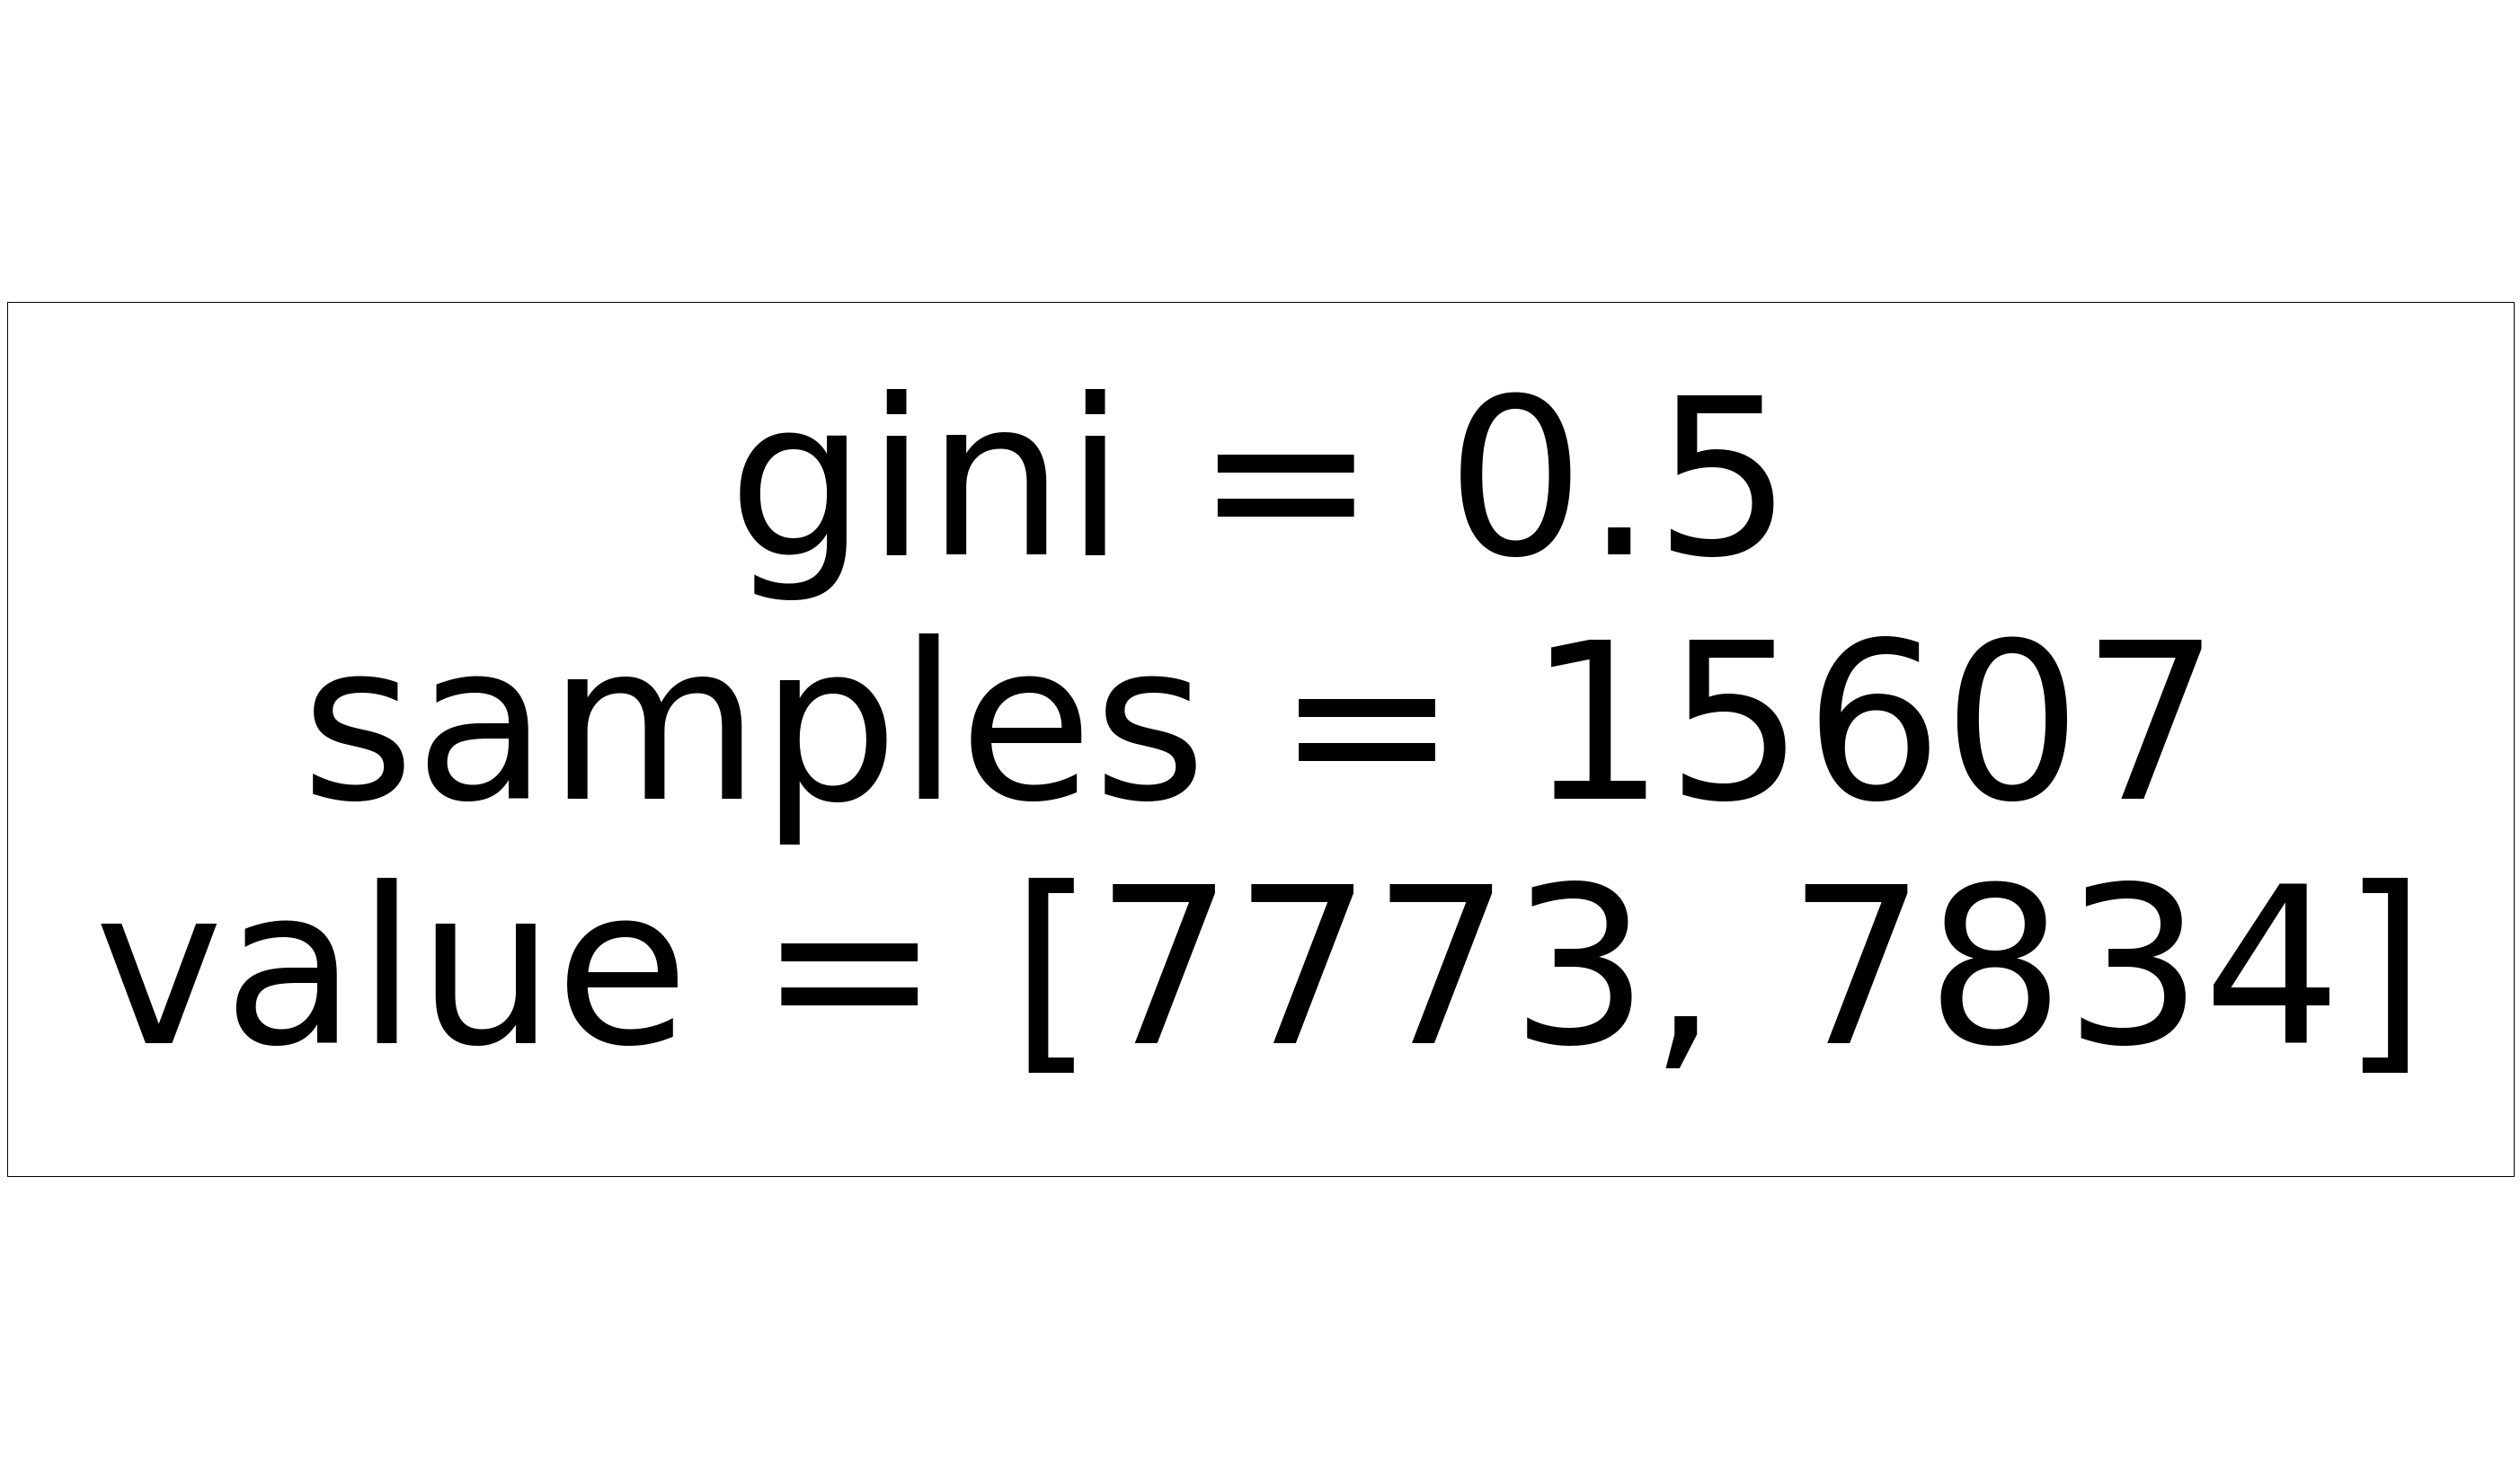

In [47]:
# Get predictions
preds = dt.predict(X_test)
prob = np.round(dt.predict_proba(X_test), 3)

model_stats(dt, X_test, y_test)

# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(dt);

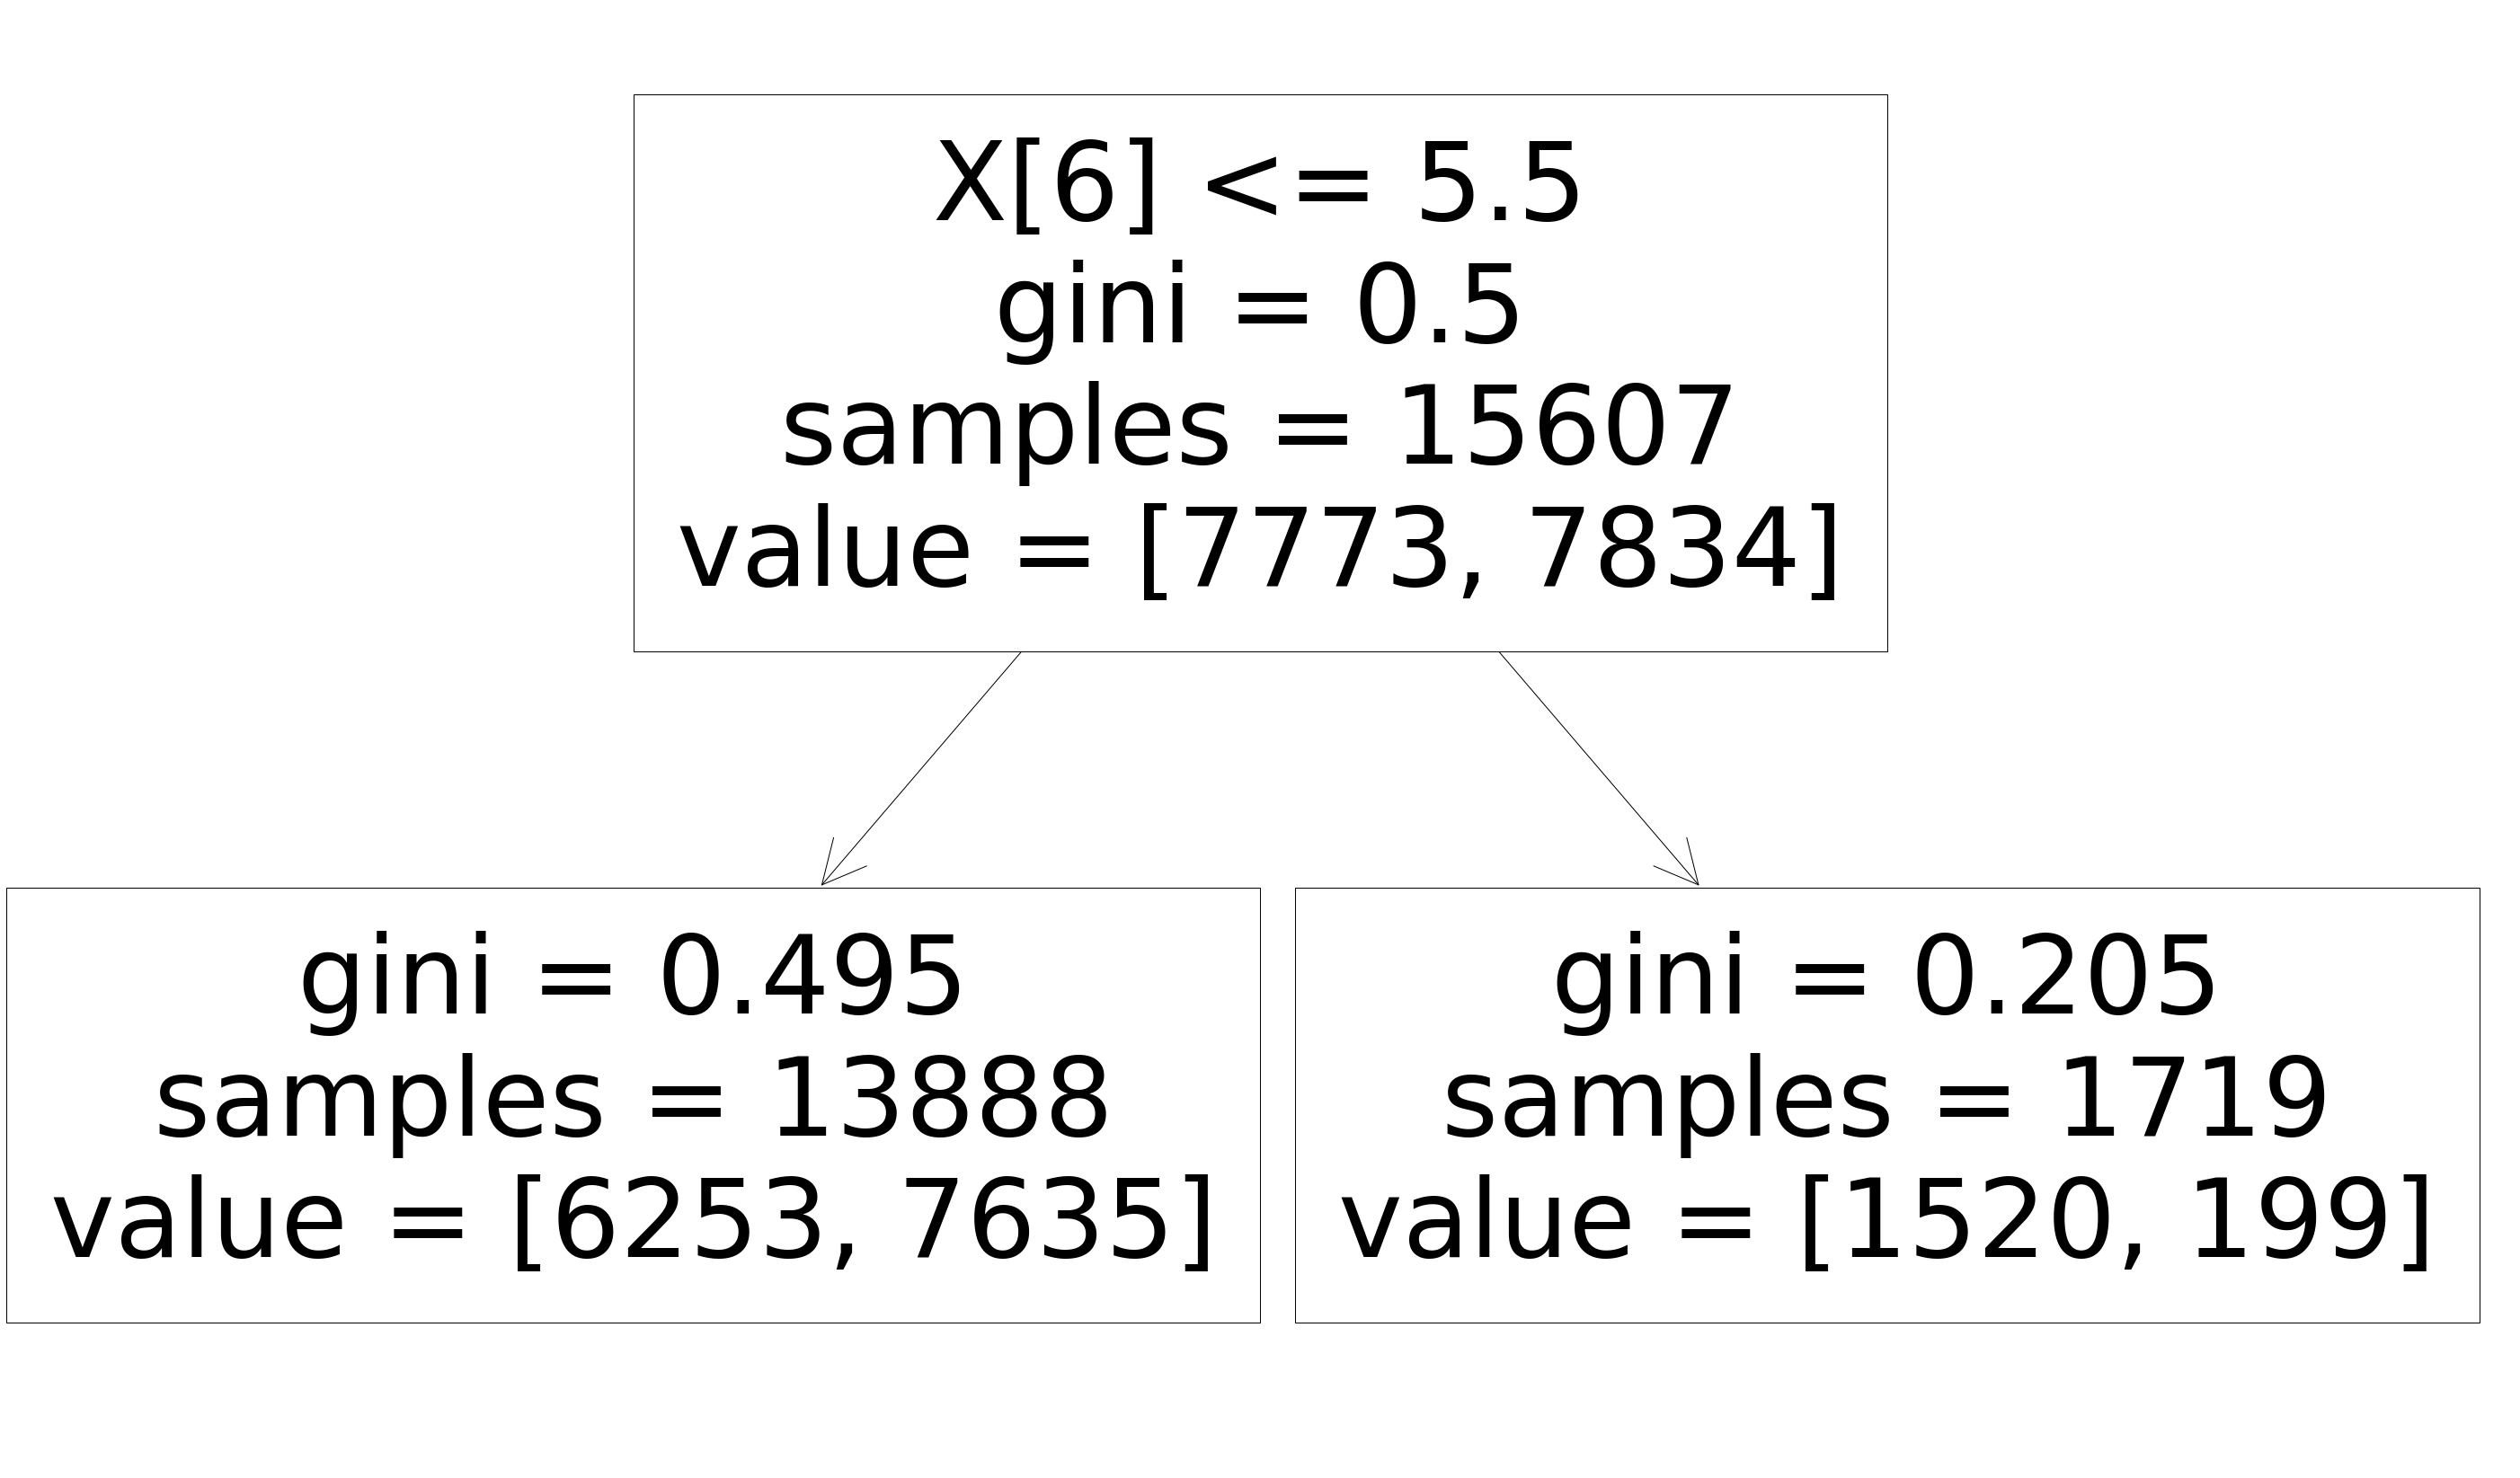

In [36]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(dt);

In [38]:
# save the model to disk
filename = 'dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5727313499775751


Training Score: 0.587
Test Score:     0.573
Specificity:     0.184
Precision:       0.538
Recall:          0.969
Accuracy Score:  0.573
F1:              0.692
True Negatives:  621
False Positives: 2754
False Negatives: 104
True Positives:  3210


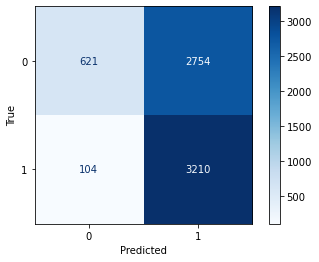

In [43]:
final_preds = loaded_model.predict(X_test)
final_prob = np.round(loaded_model.predict_proba(X_test),3)

model_stats(loaded_model, X_test, y_test)

# View confusion matrix

plot_confusion_matrix(loaded_model, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [48]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]},
                    cv = 5,
                    verbose = 1)

In [49]:
import time

t0 = time.time()

grid.fit(X_train, y_train)
print(time.time() - t0)

Fitting 5 folds for each of 8008 candidates, totalling 40040 fits
1320.2381269931793


In [50]:
# What is our best decision tree?
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=21, min_samples_leaf=2,
                       min_samples_split=5)

In [51]:
grid.best_score_

0.8176451969988594

In [52]:
# Evaluate model.
print(f'Score on training set: {grid.score(X_train, y_train)}')
print(f'Score on testing set: {grid.score(X_test, y_test)}')

Score on training set: 0.9164477478054719
Score on testing set: 0.8276274480490358


In [53]:
# Generate predictions on test set.
preds = grid.predict(X_test)

In [54]:
# Get predictions
preds = grid.predict(X_test)
prob = np.round(dt.predict_proba(X_test), 3)

model_stats(grid, X_test, y_test)

Training Score: 0.916
Test Score:     0.828
Specificity:     0.794
Precision:       0.804
Recall:          0.862
Accuracy Score:  0.828
F1:              0.832
True Negatives:  2680
False Positives: 695
False Negatives: 458
True Positives:  2856


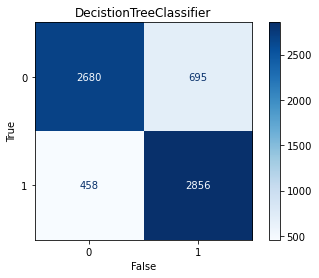

In [55]:
# View confusion matrix

plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', values_format='d');
plt.title("DecistionTreeClassifier")
plt.xlabel('False')
plt.ylabel('True')
plt.show()

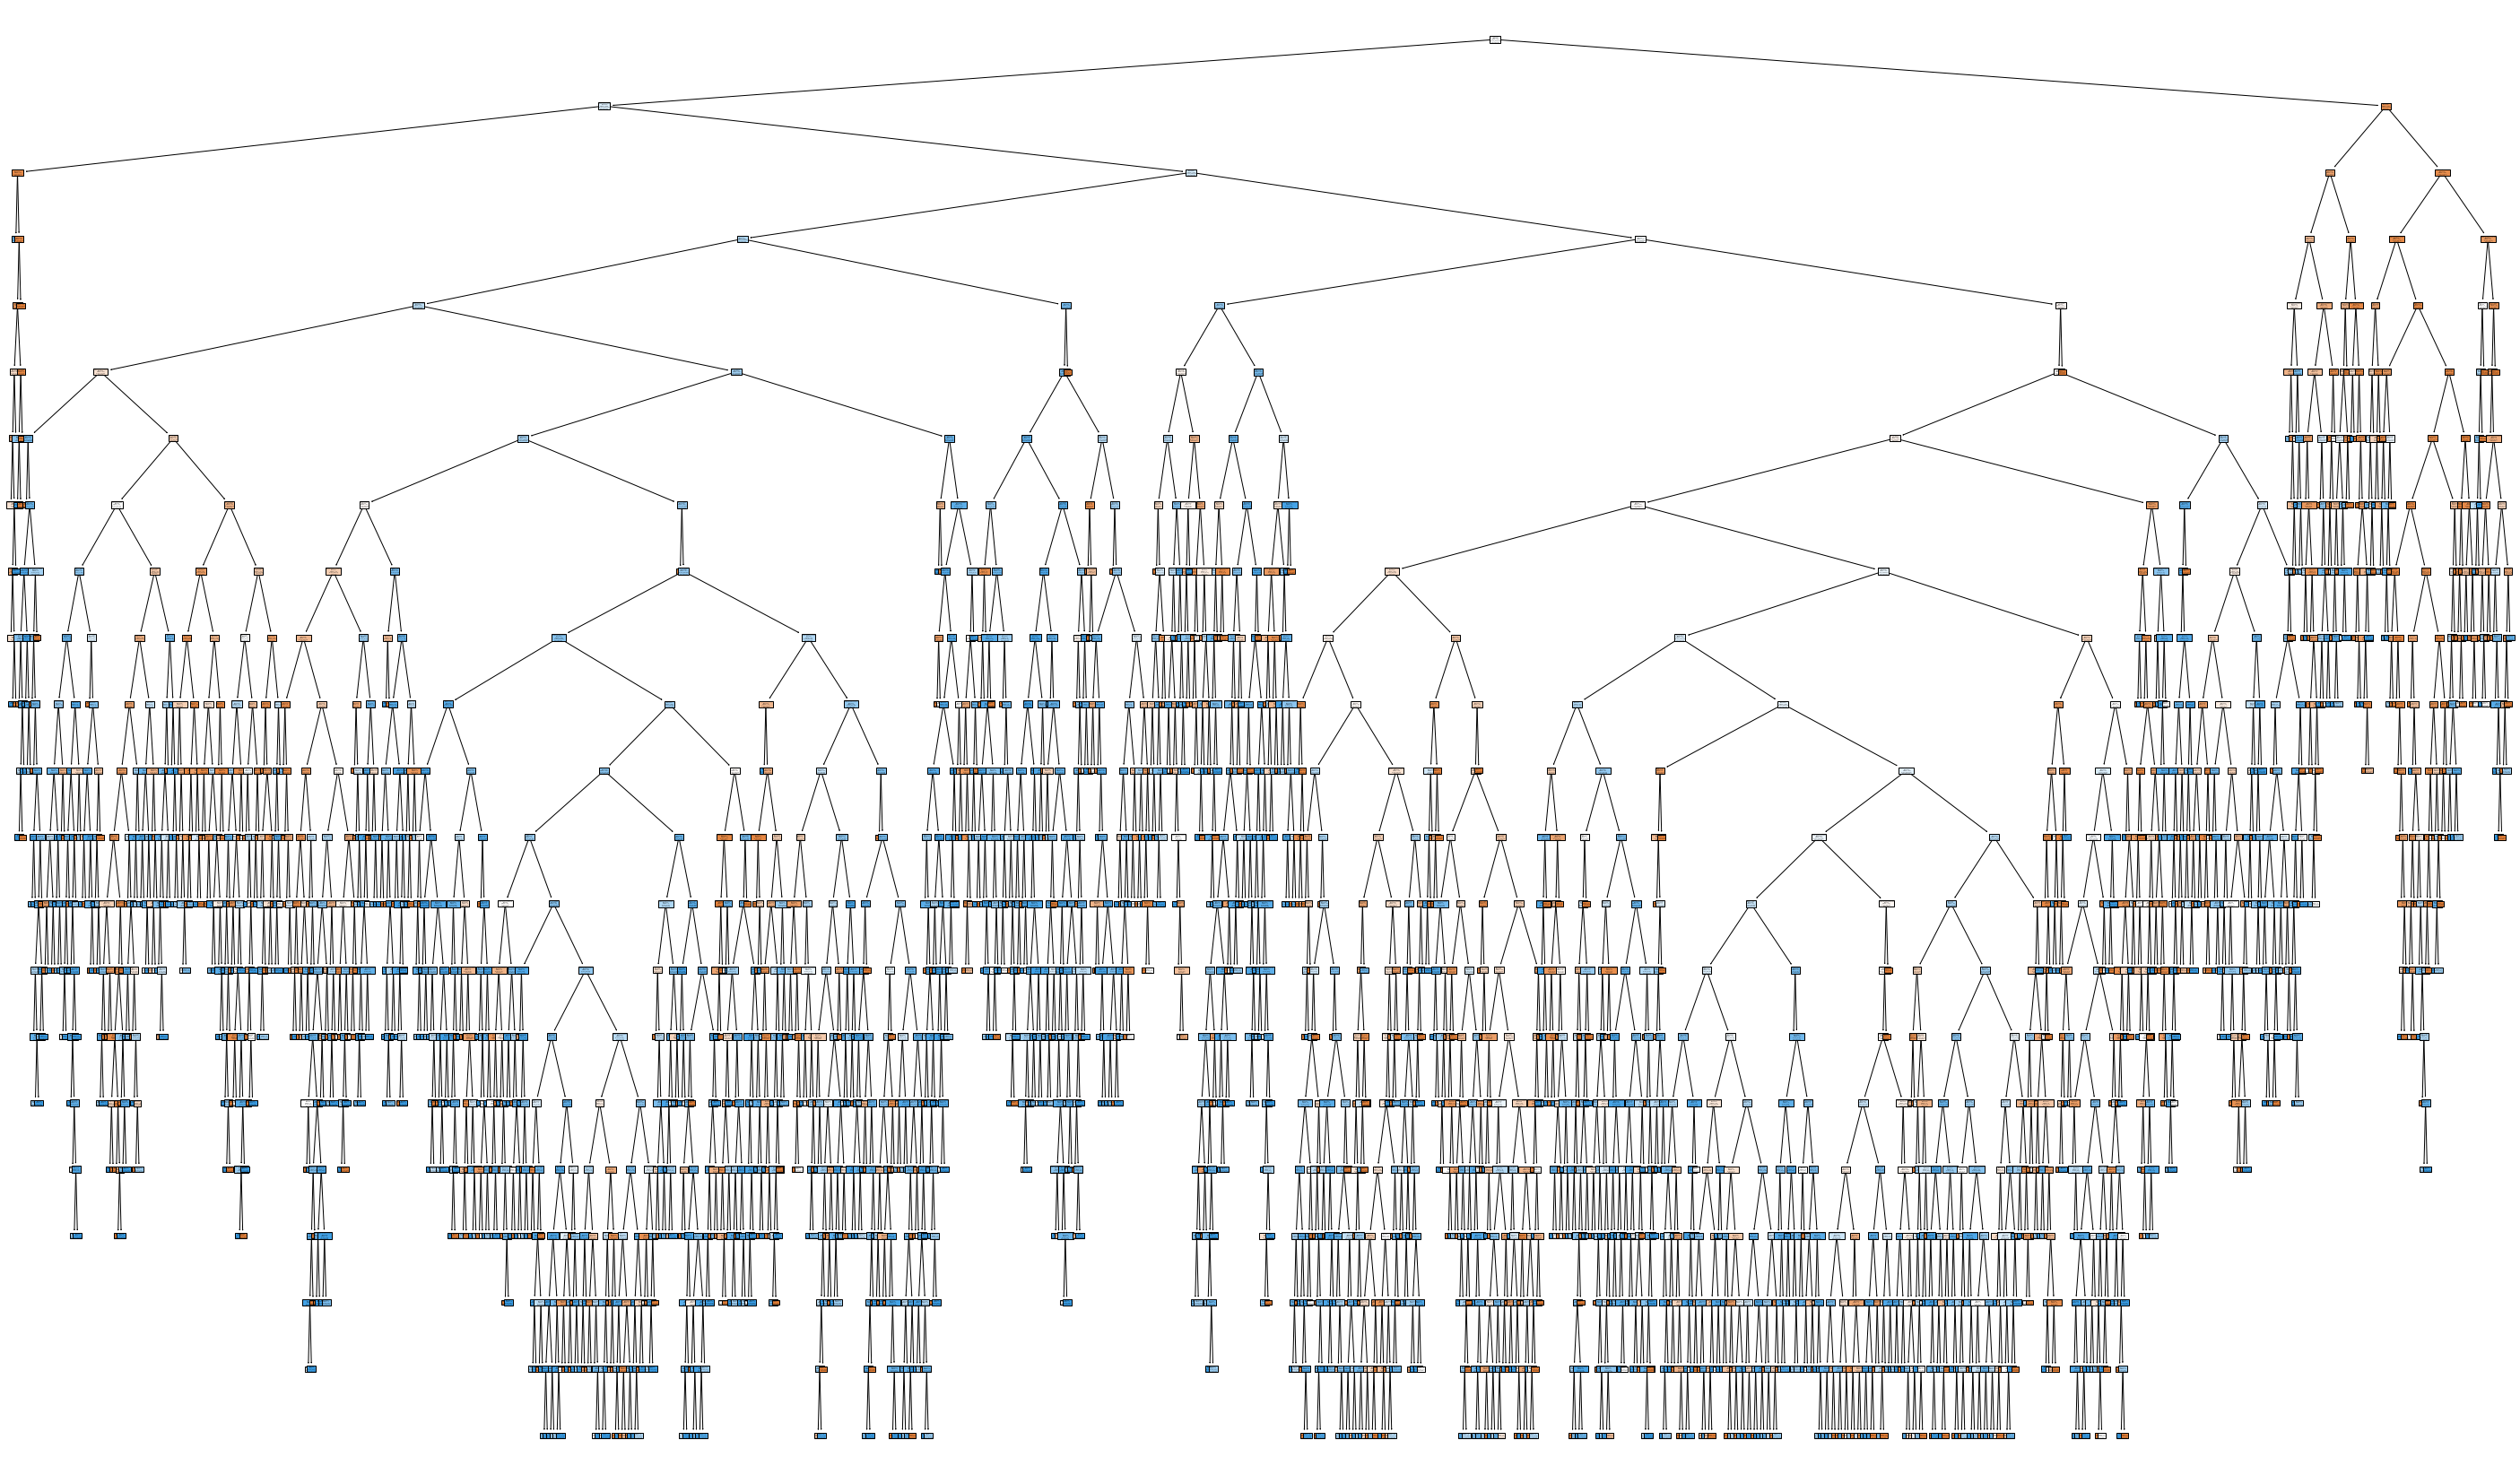

In [56]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(grid.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Paid', 'Defaulted'],
          filled = True);

Baseline: ROC AUC=0.500
DecisionTree: ROC AUC=0.500


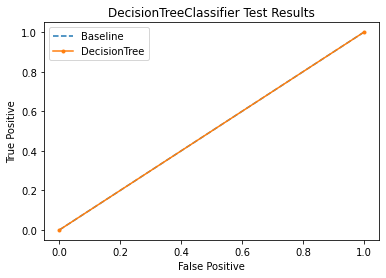

In [57]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('DecisionTree: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='DecisionTree')

# Title
plt.title('DecisionTreeClassifier Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


# AdaBoostClassifier

In [58]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification

0.8249666539040309
{'base_estimator__max_depth': 7, 'learning_rate': 0.9, 'n_estimators': 100}
Training Score: 0.894
Test Score:     0.824
Specificity:     0.945
Precision:       0.644
Recall:          0.369
Accuracy Score:  0.824
F1:              0.469
True Negatives:  2635
False Positives: 152
False Negatives: 471
True Positives:  275


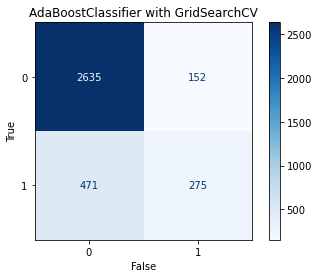

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm="SAMME", n_estimators=200)
ada_params = {
    'n_estimators': [50,100, 110, 120, 130, 140, 150, 160],
    'base_estimator__max_depth': [1,2,3,4,5,6,7,8,9,10],
    'learning_rate': [.9, 1.]
}
gs_ada = GridSearchCV(ada, n_jobs=-1, param_grid=ada_params, cv=5)
gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

preds = gs_ada.predict(X_test)
prob = np.round(gs_ada.predict_proba(X_test), 3)

model_stats(gs_ada, X_test, y_test)

# View confusion matrix
plot_confusion_matrix(gs_ada, X_test, y_test, cmap='Blues', values_format='d');
plt.title("AdaBoostClassifier with GridSearchCV")
plt.xlabel('False')
plt.ylabel('True')
plt.show()

# GradientBoostingClassifier

0.823457431025406
{'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 200}
Training Score: 0.851
Test Score:     0.819
Specificity:     0.965
Precision:       0.678
Recall:          0.273
Accuracy Score:  0.819
F1:              0.39
True Negatives:  2690
False Positives: 97
False Negatives: 542
True Positives:  204


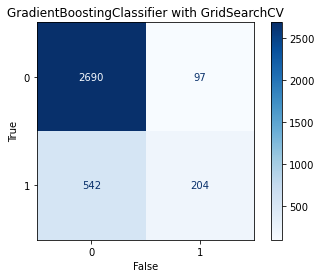

In [60]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(gboost, n_jobs=-1, param_grid=gboost_params, cv=3)
gb_gs.fit(X_train, y_train)

print(gb_gs.best_score_)
print(gb_gs.best_params_)

# Get predictions
preds = gb_gs.predict(X_test)
prob = np.round(gb_gs.predict_proba(X_test), 3)

model_stats(gb_gs, X_test, y_test)

# View confusion matrix
plot_confusion_matrix(gb_gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title("GradientBoostingClassifier with GridSearchCV")
plt.xlabel('False')
plt.ylabel('True')
plt.show()

# VotingClassifier

0.8142100469530823
{'ada__n_estimators': 175, 'gb__n_estimators': 200, 'tree__max_depth': None}
Training Score: 0.851
Test Score:     0.819
Specificity:     0.965
Precision:       0.678
Recall:          0.273
Accuracy Score:  0.819
F1:              0.39
True Negatives:  2690
False Positives: 97
False Negatives: 542
True Positives:  204


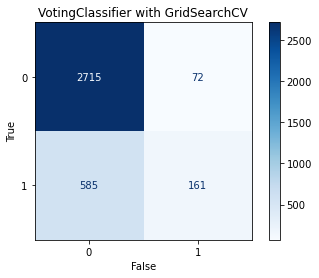

In [61]:
vote = VotingClassifier([
    ('tree', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
])
vote_params = {
    'ada__n_estimators': [25,50,75,100,125,150,175,200],
    'gb__n_estimators': [100,125,150,175,200],
    'tree__max_depth': [None, 1,2,3,4,5,6,7,8,9,10]
}
gs_vc = GridSearchCV(vote, n_jobs = -1, param_grid=vote_params, cv=3)
gs_vc.fit(X_train, y_train)
print(gs_vc.best_score_)
print(gs_vc.best_params_)

# Get predictions
preds = gb_gs.predict(X_test)
prob = np.round(gb_gs.predict_proba(X_test), 3)

model_stats(gb_gs, X_test, y_test)
# View confusion matrix
plot_confusion_matrix(gs_vc, X_test, y_test, cmap='Blues', values_format='d');
plt.title("VotingClassifier with GridSearchCV")
plt.xlabel('False')
plt.ylabel('True')
plt.show()